In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Loading data
***Dataset:*** [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/data)

In [2]:
training = pd.read_csv(os.path.join('data', 'training', 'training.csv'))
test = pd.read_csv(os.path.join('data', 'test', 'test.csv'))

In [3]:
test.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


### Process training images
Image data is provided as a str of gray scale intensities.
- Image size is 96x96

In [4]:
x_train = training['Image']

In [5]:
x_train.head()

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
3    193 192 193 194 194 194 193 192 168 111 50 12 ...
4    147 148 160 196 215 214 216 217 219 220 206 18...
Name: Image, dtype: object

In [6]:
def str2img(strarr):
    img = strarr.split(' ')
    img = ['0' if x == '' else x for x in img]
    return img

def process_X(X):
    imag = [str2img(x) for x in X]
    image_list = np.array(imag,dtype = 'float')
    return image_list.reshape(-1,96,96,1)

In [7]:
x_train = process_X(x_train)

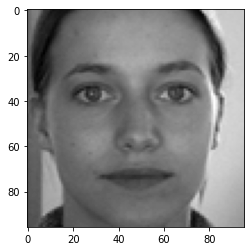

In [8]:
plt.imshow(x_train[69].reshape(96,96),cmap='gray')
plt.show()

### Process labels
- Fill missing values with forward fill, which uses last valid value.

In [9]:
y_train = training.loc[:, training.columns != 'Image']
y_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [10]:
sum(y_train.isnull().any())

28

In [11]:
y_train.fillna(method = 'ffill',inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [12]:
sum(y_train.isnull().any())

0

In [13]:
y = y_train.copy()

y_train = []
for i in range(len(y)):
    y_train.append(y.iloc[i,:])

y_train = np.array(y, dtype='float')

In [14]:
print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')

x_train.shape = (7049, 96, 96, 1)
y_train.shape = (7049, 30)


# Model

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [16]:
num_keypoints = 15

## Baseline model

In [17]:
model_baseline = tf.keras.models.Sequential([
    Conv2D(96, kernel_size=(7,7), strides=(3,3), padding='valid', input_shape=(96,96,1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((3,3), strides=(2,2)),
    
    Conv2D(192, kernel_size=(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    
    Conv2D(384, kernel_size=(3,3), padding='valid'),
    BatchNormalization(),
    Activation('relu'),
    
    Flatten(),
    Dense(num_keypoints * 2)
])

In [18]:
opt = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()
model_baseline.compile(optimizer=opt, loss=loss_fn, metrics=['mae'])

In [45]:
model_baseline.fit(x_train, y_train, epochs=2000, batch_size=256, validation_split=0.2)

Epoch 1/2000
23/23 [==============================] - 1s 58ms/step - loss: 302.4171 - mean_absolute_error: 11.9013 - val_loss: 24895.9707 - val_mean_absolute_error: 137.1873
Epoch 2/2000
23/23 [==============================] - 1s 48ms/step - loss: 21.6993 - mean_absolute_error: 3.5337 - val_loss: 7664.6406 - val_mean_absolute_error: 76.1092
Epoch 3/2000
23/23 [==============================] - 1s 50ms/step - loss: 11.1264 - mean_absolute_error: 2.3282 - val_loss: 524.9815 - val_mean_absolute_error: 17.5943
Epoch 4/2000
23/23 [==============================] - 1s 49ms/step - loss: 8.3221 - mean_absolute_error: 1.9251 - val_loss: 114.5491 - val_mean_absolute_error: 8.2771
Epoch 5/2000
23/23 [==============================] - 1s 48ms/step - loss: 7.4817 - mean_absolute_error: 1.8002 - val_loss: 97.9702 - val_mean_absolute_error: 8.0886
Epoch 6/2000
23/23 [==============================] - 1s 48ms/step - loss: 7.6814 - mean_absolute_error: 1.8624 - val_loss: 89.6968 - val_mean_absolute_er

23/23 [==============================] - 1s 48ms/step - loss: 3.2257 - mean_absolute_error: 1.2166 - val_loss: 5.0338 - val_mean_absolute_error: 1.5788
Epoch 51/2000
23/23 [==============================] - 1s 47ms/step - loss: 3.4158 - mean_absolute_error: 1.2746 - val_loss: 4.7805 - val_mean_absolute_error: 1.5391
Epoch 52/2000
23/23 [==============================] - 1s 48ms/step - loss: 2.9239 - mean_absolute_error: 1.1451 - val_loss: 4.6416 - val_mean_absolute_error: 1.5300
Epoch 53/2000
23/23 [==============================] - 1s 48ms/step - loss: 3.1807 - mean_absolute_error: 1.2232 - val_loss: 4.5428 - val_mean_absolute_error: 1.5216
Epoch 54/2000
23/23 [==============================] - 1s 51ms/step - loss: 3.1214 - mean_absolute_error: 1.2216 - val_loss: 5.2096 - val_mean_absolute_error: 1.6733
Epoch 55/2000
23/23 [==============================] - 1s 48ms/step - loss: 2.8381 - mean_absolute_error: 1.1435 - val_loss: 10.8249 - val_mean_absolute_error: 2.6582
Epoch 56/2000
23/

23/23 [==============================] - 1s 48ms/step - loss: 1.7820 - mean_absolute_error: 0.9905 - val_loss: 10.4346 - val_mean_absolute_error: 2.4391
Epoch 100/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.6359 - mean_absolute_error: 0.9488 - val_loss: 4.9370 - val_mean_absolute_error: 1.4903
Epoch 101/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.2477 - mean_absolute_error: 0.8043 - val_loss: 4.0313 - val_mean_absolute_error: 1.3692
Epoch 102/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.2309 - mean_absolute_error: 0.8093 - val_loss: 4.7373 - val_mean_absolute_error: 1.4962
Epoch 103/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.3458 - mean_absolute_error: 0.8584 - val_loss: 8.4660 - val_mean_absolute_error: 2.0645
Epoch 104/2000
23/23 [==============================] - 1s 49ms/step - loss: 1.8363 - mean_absolute_error: 1.0050 - val_loss: 3.9324 - val_mean_absolute_error: 1.3531
Epoch 105/20

23/23 [==============================] - 1s 48ms/step - loss: 1.3205 - mean_absolute_error: 0.8530 - val_loss: 4.0300 - val_mean_absolute_error: 1.3505
Epoch 149/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.9772 - mean_absolute_error: 0.7259 - val_loss: 4.3537 - val_mean_absolute_error: 1.4532
Epoch 150/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.1244 - mean_absolute_error: 0.8000 - val_loss: 4.6771 - val_mean_absolute_error: 1.5108
Epoch 151/2000
23/23 [==============================] - 1s 50ms/step - loss: 0.9208 - mean_absolute_error: 0.7232 - val_loss: 7.7473 - val_mean_absolute_error: 2.0466
Epoch 152/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.9311 - mean_absolute_error: 1.0468 - val_loss: 3.9413 - val_mean_absolute_error: 1.3565
Epoch 153/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.8443 - mean_absolute_error: 0.6890 - val_loss: 8.2612 - val_mean_absolute_error: 2.2526
Epoch 154/200

23/23 [==============================] - 1s 49ms/step - loss: 0.7693 - mean_absolute_error: 0.6491 - val_loss: 10.4665 - val_mean_absolute_error: 2.6451
Epoch 198/2000
23/23 [==============================] - 1s 48ms/step - loss: 2.2673 - mean_absolute_error: 1.1966 - val_loss: 5.4944 - val_mean_absolute_error: 1.7847
Epoch 199/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.9101 - mean_absolute_error: 0.7231 - val_loss: 3.3944 - val_mean_absolute_error: 1.2132
Epoch 200/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.6224 - mean_absolute_error: 0.5659 - val_loss: 5.6696 - val_mean_absolute_error: 1.8028
Epoch 201/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.7985 - mean_absolute_error: 0.6823 - val_loss: 5.8503 - val_mean_absolute_error: 1.7981
Epoch 202/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.8903 - mean_absolute_error: 0.7006 - val_loss: 8.1112 - val_mean_absolute_error: 2.2946
Epoch 203/20

23/23 [==============================] - 1s 47ms/step - loss: 0.7461 - mean_absolute_error: 0.6471 - val_loss: 3.8916 - val_mean_absolute_error: 1.2826
Epoch 247/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.5702 - mean_absolute_error: 0.5517 - val_loss: 7.4622 - val_mean_absolute_error: 2.0036
Epoch 248/2000
23/23 [==============================] - 1s 47ms/step - loss: 1.0956 - mean_absolute_error: 0.8085 - val_loss: 4.4490 - val_mean_absolute_error: 1.4343
Epoch 249/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.5920 - mean_absolute_error: 0.5638 - val_loss: 5.1083 - val_mean_absolute_error: 1.5617
Epoch 250/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.2198 - mean_absolute_error: 0.8205 - val_loss: 4.7392 - val_mean_absolute_error: 1.4991
Epoch 251/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.9593 - mean_absolute_error: 0.7212 - val_loss: 3.8128 - val_mean_absolute_error: 1.3010
Epoch 252/200

23/23 [==============================] - 1s 48ms/step - loss: 0.7436 - mean_absolute_error: 0.6538 - val_loss: 4.0577 - val_mean_absolute_error: 1.3194
Epoch 296/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.8533 - mean_absolute_error: 0.6914 - val_loss: 7.7018 - val_mean_absolute_error: 1.9947
Epoch 297/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.5325 - mean_absolute_error: 0.9043 - val_loss: 3.7275 - val_mean_absolute_error: 1.2502
Epoch 298/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.7976 - mean_absolute_error: 0.6593 - val_loss: 3.9543 - val_mean_absolute_error: 1.3602
Epoch 299/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.7077 - mean_absolute_error: 0.6290 - val_loss: 5.1532 - val_mean_absolute_error: 1.6941
Epoch 300/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.7056 - mean_absolute_error: 0.6148 - val_loss: 3.5927 - val_mean_absolute_error: 1.2460
Epoch 301/200

23/23 [==============================] - 1s 48ms/step - loss: 0.4801 - mean_absolute_error: 0.4894 - val_loss: 3.2928 - val_mean_absolute_error: 1.1587
Epoch 345/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3060 - mean_absolute_error: 0.3673 - val_loss: 4.1111 - val_mean_absolute_error: 1.3223
Epoch 346/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.3928 - mean_absolute_error: 0.4334 - val_loss: 4.5681 - val_mean_absolute_error: 1.4563
Epoch 347/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.8536 - mean_absolute_error: 0.6819 - val_loss: 3.6728 - val_mean_absolute_error: 1.2744
Epoch 348/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.5837 - mean_absolute_error: 0.5562 - val_loss: 3.5503 - val_mean_absolute_error: 1.2210
Epoch 349/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3871 - mean_absolute_error: 0.4367 - val_loss: 3.1573 - val_mean_absolute_error: 1.1029
Epoch 350/200

23/23 [==============================] - 1s 47ms/step - loss: 1.5198 - mean_absolute_error: 0.9464 - val_loss: 4.5931 - val_mean_absolute_error: 1.5094
Epoch 394/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.5359 - mean_absolute_error: 0.5196 - val_loss: 9.8093 - val_mean_absolute_error: 2.3209
Epoch 395/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.4046 - mean_absolute_error: 0.8314 - val_loss: 22.1998 - val_mean_absolute_error: 3.8632
Epoch 396/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.8103 - mean_absolute_error: 0.6550 - val_loss: 4.4455 - val_mean_absolute_error: 1.4889
Epoch 397/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.6395 - mean_absolute_error: 0.5931 - val_loss: 3.8205 - val_mean_absolute_error: 1.3240
Epoch 398/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.5946 - mean_absolute_error: 0.5736 - val_loss: 4.2172 - val_mean_absolute_error: 1.4941
Epoch 399/20

23/23 [==============================] - 1s 48ms/step - loss: 1.1385 - mean_absolute_error: 0.7845 - val_loss: 4.5906 - val_mean_absolute_error: 1.4466
Epoch 443/2000
23/23 [==============================] - 1s 47ms/step - loss: 1.3853 - mean_absolute_error: 0.9106 - val_loss: 3.4652 - val_mean_absolute_error: 1.2226
Epoch 444/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.6436 - mean_absolute_error: 0.5970 - val_loss: 5.4781 - val_mean_absolute_error: 1.6179
Epoch 445/2000
23/23 [==============================] - 1s 48ms/step - loss: 1.1403 - mean_absolute_error: 0.8031 - val_loss: 4.5949 - val_mean_absolute_error: 1.4158
Epoch 446/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.6136 - mean_absolute_error: 0.5670 - val_loss: 3.2211 - val_mean_absolute_error: 1.1295
Epoch 447/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.3414 - mean_absolute_error: 0.3989 - val_loss: 3.3284 - val_mean_absolute_error: 1.1674
Epoch 448/200

23/23 [==============================] - 1s 47ms/step - loss: 0.2455 - mean_absolute_error: 0.3172 - val_loss: 3.9369 - val_mean_absolute_error: 1.3351
Epoch 492/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.4867 - mean_absolute_error: 0.5126 - val_loss: 3.8505 - val_mean_absolute_error: 1.3558
Epoch 493/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.4799 - mean_absolute_error: 0.5102 - val_loss: 5.2079 - val_mean_absolute_error: 1.5955
Epoch 494/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.6790 - mean_absolute_error: 0.5750 - val_loss: 3.3378 - val_mean_absolute_error: 1.1498
Epoch 495/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3694 - mean_absolute_error: 0.4130 - val_loss: 3.4084 - val_mean_absolute_error: 1.1616
Epoch 496/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3768 - mean_absolute_error: 0.4340 - val_loss: 3.1943 - val_mean_absolute_error: 1.1377
Epoch 497/200

23/23 [==============================] - 1s 48ms/step - loss: 0.8804 - mean_absolute_error: 0.7388 - val_loss: 3.4600 - val_mean_absolute_error: 1.2559
Epoch 541/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.4436 - mean_absolute_error: 0.4836 - val_loss: 3.2908 - val_mean_absolute_error: 1.1350
Epoch 542/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.3044 - mean_absolute_error: 0.3706 - val_loss: 3.7337 - val_mean_absolute_error: 1.2219
Epoch 543/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3037 - mean_absolute_error: 0.3629 - val_loss: 3.2808 - val_mean_absolute_error: 1.1181
Epoch 544/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.4170 - mean_absolute_error: 0.4631 - val_loss: 3.4986 - val_mean_absolute_error: 1.2299
Epoch 545/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.4859 - mean_absolute_error: 0.5054 - val_loss: 3.2735 - val_mean_absolute_error: 1.1783
Epoch 546/200

23/23 [==============================] - 1s 47ms/step - loss: 0.2962 - mean_absolute_error: 0.3681 - val_loss: 3.4623 - val_mean_absolute_error: 1.1956
Epoch 590/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.4293 - mean_absolute_error: 0.4701 - val_loss: 6.0108 - val_mean_absolute_error: 1.7948
Epoch 591/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.6162 - mean_absolute_error: 0.5848 - val_loss: 7.9352 - val_mean_absolute_error: 2.0641
Epoch 592/2000
23/23 [==============================] - 1s 47ms/step - loss: 1.0437 - mean_absolute_error: 0.7083 - val_loss: 3.5030 - val_mean_absolute_error: 1.1880
Epoch 593/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.5554 - mean_absolute_error: 0.5145 - val_loss: 3.1242 - val_mean_absolute_error: 1.1176
Epoch 594/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.3201 - mean_absolute_error: 0.3755 - val_loss: 3.1244 - val_mean_absolute_error: 1.0800
Epoch 595/200

23/23 [==============================] - 1s 48ms/step - loss: 0.2189 - mean_absolute_error: 0.2939 - val_loss: 4.0006 - val_mean_absolute_error: 1.3996
Epoch 639/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.3034 - mean_absolute_error: 0.3730 - val_loss: 3.0646 - val_mean_absolute_error: 1.1109
Epoch 640/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.1978 - mean_absolute_error: 0.2697 - val_loss: 4.2759 - val_mean_absolute_error: 1.3952
Epoch 641/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3990 - mean_absolute_error: 0.4449 - val_loss: 3.2760 - val_mean_absolute_error: 1.1172
Epoch 642/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2773 - mean_absolute_error: 0.3348 - val_loss: 3.3459 - val_mean_absolute_error: 1.1771
Epoch 643/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.3388 - mean_absolute_error: 0.3862 - val_loss: 3.1518 - val_mean_absolute_error: 1.1061
Epoch 644/200

23/23 [==============================] - 1s 48ms/step - loss: 0.2993 - mean_absolute_error: 0.3646 - val_loss: 3.8725 - val_mean_absolute_error: 1.2751
Epoch 688/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.3619 - mean_absolute_error: 0.4126 - val_loss: 3.2585 - val_mean_absolute_error: 1.1274
Epoch 689/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2485 - mean_absolute_error: 0.3197 - val_loss: 2.9029 - val_mean_absolute_error: 1.0161
Epoch 690/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2258 - mean_absolute_error: 0.2997 - val_loss: 2.9691 - val_mean_absolute_error: 1.0834
Epoch 691/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2227 - mean_absolute_error: 0.2990 - val_loss: 3.2168 - val_mean_absolute_error: 1.1639
Epoch 692/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2321 - mean_absolute_error: 0.3074 - val_loss: 3.0284 - val_mean_absolute_error: 1.0677
Epoch 693/200

23/23 [==============================] - 1s 46ms/step - loss: 1.0194 - mean_absolute_error: 0.7591 - val_loss: 2.8572 - val_mean_absolute_error: 1.0590
Epoch 737/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.3837 - mean_absolute_error: 0.4214 - val_loss: 2.8793 - val_mean_absolute_error: 1.0331
Epoch 738/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.3555 - mean_absolute_error: 0.3977 - val_loss: 3.1478 - val_mean_absolute_error: 1.0920
Epoch 739/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.5963 - mean_absolute_error: 0.5506 - val_loss: 3.2312 - val_mean_absolute_error: 1.1903
Epoch 740/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.4449 - mean_absolute_error: 0.4650 - val_loss: 2.9773 - val_mean_absolute_error: 1.0805
Epoch 741/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.4952 - mean_absolute_error: 0.4994 - val_loss: 3.3449 - val_mean_absolute_error: 1.1850
Epoch 742/200

23/23 [==============================] - 1s 46ms/step - loss: 0.3568 - mean_absolute_error: 0.4167 - val_loss: 3.0982 - val_mean_absolute_error: 1.1271
Epoch 786/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2511 - mean_absolute_error: 0.3307 - val_loss: 3.1119 - val_mean_absolute_error: 1.0875
Epoch 787/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2549 - mean_absolute_error: 0.3160 - val_loss: 2.8565 - val_mean_absolute_error: 1.0314
Epoch 788/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2350 - mean_absolute_error: 0.2842 - val_loss: 3.0246 - val_mean_absolute_error: 1.0717
Epoch 789/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2973 - mean_absolute_error: 0.3605 - val_loss: 2.9410 - val_mean_absolute_error: 1.0372
Epoch 790/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2550 - mean_absolute_error: 0.3222 - val_loss: 2.9597 - val_mean_absolute_error: 1.0888
Epoch 791/200

23/23 [==============================] - 1s 46ms/step - loss: 0.3520 - mean_absolute_error: 0.3829 - val_loss: 3.2811 - val_mean_absolute_error: 1.1520
Epoch 835/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2577 - mean_absolute_error: 0.3230 - val_loss: 3.1144 - val_mean_absolute_error: 1.0788
Epoch 836/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2634 - mean_absolute_error: 0.3391 - val_loss: 3.1869 - val_mean_absolute_error: 1.0791
Epoch 837/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2818 - mean_absolute_error: 0.3404 - val_loss: 2.8939 - val_mean_absolute_error: 1.0691
Epoch 838/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2133 - mean_absolute_error: 0.3014 - val_loss: 2.9169 - val_mean_absolute_error: 1.0306
Epoch 839/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1506 - mean_absolute_error: 0.2174 - val_loss: 2.8923 - val_mean_absolute_error: 1.0005
Epoch 840/200

23/23 [==============================] - 1s 46ms/step - loss: 0.2027 - mean_absolute_error: 0.2821 - val_loss: 2.9014 - val_mean_absolute_error: 1.0205
Epoch 884/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1901 - mean_absolute_error: 0.2631 - val_loss: 2.9309 - val_mean_absolute_error: 1.0239
Epoch 885/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1999 - mean_absolute_error: 0.2731 - val_loss: 4.6975 - val_mean_absolute_error: 1.4765
Epoch 886/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.5165 - mean_absolute_error: 0.4965 - val_loss: 4.5550 - val_mean_absolute_error: 1.5084
Epoch 887/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.4181 - mean_absolute_error: 0.4029 - val_loss: 2.8362 - val_mean_absolute_error: 1.0498
Epoch 888/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2310 - mean_absolute_error: 0.3020 - val_loss: 2.8161 - val_mean_absolute_error: 1.0016
Epoch 889/200

23/23 [==============================] - 1s 46ms/step - loss: 0.1907 - mean_absolute_error: 0.2589 - val_loss: 3.0728 - val_mean_absolute_error: 1.0591
Epoch 933/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1955 - mean_absolute_error: 0.2691 - val_loss: 2.6812 - val_mean_absolute_error: 0.9687
Epoch 934/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1888 - mean_absolute_error: 0.2636 - val_loss: 2.8892 - val_mean_absolute_error: 1.0641
Epoch 935/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1799 - mean_absolute_error: 0.2525 - val_loss: 3.2367 - val_mean_absolute_error: 1.1212
Epoch 936/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2535 - mean_absolute_error: 0.3399 - val_loss: 3.3689 - val_mean_absolute_error: 1.1762
Epoch 937/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2199 - mean_absolute_error: 0.2893 - val_loss: 4.0860 - val_mean_absolute_error: 1.3758
Epoch 938/200

23/23 [==============================] - 1s 46ms/step - loss: 0.1617 - mean_absolute_error: 0.2225 - val_loss: 3.1475 - val_mean_absolute_error: 1.1008
Epoch 982/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1855 - mean_absolute_error: 0.2562 - val_loss: 2.7194 - val_mean_absolute_error: 1.0080
Epoch 983/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1951 - mean_absolute_error: 0.2698 - val_loss: 3.1991 - val_mean_absolute_error: 1.0982
Epoch 984/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1893 - mean_absolute_error: 0.2633 - val_loss: 3.4988 - val_mean_absolute_error: 1.2426
Epoch 985/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2387 - mean_absolute_error: 0.3219 - val_loss: 3.5276 - val_mean_absolute_error: 1.2231
Epoch 986/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2662 - mean_absolute_error: 0.3391 - val_loss: 2.9260 - val_mean_absolute_error: 1.0151
Epoch 987/200

Epoch 1030/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1768 - mean_absolute_error: 0.2387 - val_loss: 3.0094 - val_mean_absolute_error: 1.0639
Epoch 1031/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1870 - mean_absolute_error: 0.2649 - val_loss: 2.7544 - val_mean_absolute_error: 1.0202
Epoch 1032/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2062 - mean_absolute_error: 0.2758 - val_loss: 2.9616 - val_mean_absolute_error: 1.0222
Epoch 1033/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1935 - mean_absolute_error: 0.2626 - val_loss: 3.6698 - val_mean_absolute_error: 1.2759
Epoch 1034/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.3032 - mean_absolute_error: 0.3648 - val_loss: 3.1599 - val_mean_absolute_error: 1.1921
Epoch 1035/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1918 - mean_absolute_error: 0.2534 - val_loss: 2.8246 - val_mean_absolute_error:

Epoch 1079/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2059 - mean_absolute_error: 0.2607 - val_loss: 2.9367 - val_mean_absolute_error: 1.0339
Epoch 1080/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2160 - mean_absolute_error: 0.2881 - val_loss: 3.4029 - val_mean_absolute_error: 1.1899
Epoch 1081/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.3756 - mean_absolute_error: 0.3982 - val_loss: 6.0290 - val_mean_absolute_error: 1.7530
Epoch 1082/2000
23/23 [==============================] - 1s 46ms/step - loss: 1.0632 - mean_absolute_error: 0.6900 - val_loss: 5.3716 - val_mean_absolute_error: 1.6983
Epoch 1083/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.5390 - mean_absolute_error: 0.5133 - val_loss: 3.2562 - val_mean_absolute_error: 1.1526
Epoch 1084/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2818 - mean_absolute_error: 0.3420 - val_loss: 3.3749 - val_mean_absolute_error:

Epoch 1128/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.2735 - mean_absolute_error: 0.3263 - val_loss: 3.1623 - val_mean_absolute_error: 1.0902
Epoch 1129/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2661 - mean_absolute_error: 0.3244 - val_loss: 2.9204 - val_mean_absolute_error: 1.0775
Epoch 1130/2000
23/23 [==============================] - 1s 50ms/step - loss: 0.1780 - mean_absolute_error: 0.2395 - val_loss: 3.1752 - val_mean_absolute_error: 1.2054
Epoch 1131/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2400 - mean_absolute_error: 0.3281 - val_loss: 2.6886 - val_mean_absolute_error: 0.9806
Epoch 1132/2000
23/23 [==============================] - 1s 49ms/step - loss: 0.1676 - mean_absolute_error: 0.2368 - val_loss: 2.7368 - val_mean_absolute_error: 0.9663
Epoch 1133/2000
23/23 [==============================] - 1s 49ms/step - loss: 0.1418 - mean_absolute_error: 0.2042 - val_loss: 2.6420 - val_mean_absolute_error:

Epoch 1177/2000
23/23 [==============================] - 1s 50ms/step - loss: 0.1383 - mean_absolute_error: 0.1902 - val_loss: 3.1981 - val_mean_absolute_error: 1.0764
Epoch 1178/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1347 - mean_absolute_error: 0.1847 - val_loss: 2.7834 - val_mean_absolute_error: 0.9860
Epoch 1179/2000
23/23 [==============================] - 1s 50ms/step - loss: 0.2182 - mean_absolute_error: 0.2649 - val_loss: 2.9321 - val_mean_absolute_error: 1.0521
Epoch 1180/2000
23/23 [==============================] - 1s 49ms/step - loss: 0.2053 - mean_absolute_error: 0.2697 - val_loss: 2.8761 - val_mean_absolute_error: 1.0063
Epoch 1181/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2055 - mean_absolute_error: 0.2650 - val_loss: 3.3712 - val_mean_absolute_error: 1.1418
Epoch 1182/2000
23/23 [==============================] - 1s 49ms/step - loss: 0.2530 - mean_absolute_error: 0.3155 - val_loss: 2.6459 - val_mean_absolute_error:

Epoch 1226/2000
23/23 [==============================] - 1s 51ms/step - loss: 0.1606 - mean_absolute_error: 0.2064 - val_loss: 2.9076 - val_mean_absolute_error: 1.1062
Epoch 1227/2000
23/23 [==============================] - 1s 49ms/step - loss: 0.1750 - mean_absolute_error: 0.2374 - val_loss: 2.9082 - val_mean_absolute_error: 0.9955
Epoch 1228/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1937 - mean_absolute_error: 0.2533 - val_loss: 2.6049 - val_mean_absolute_error: 0.9394
Epoch 1229/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2211 - mean_absolute_error: 0.2933 - val_loss: 2.8616 - val_mean_absolute_error: 1.0470
Epoch 1230/2000
23/23 [==============================] - 1s 49ms/step - loss: 0.2165 - mean_absolute_error: 0.2833 - val_loss: 3.8687 - val_mean_absolute_error: 1.2692
Epoch 1231/2000
23/23 [==============================] - 1s 51ms/step - loss: 0.2888 - mean_absolute_error: 0.3536 - val_loss: 2.9385 - val_mean_absolute_error:

Epoch 1275/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.5000 - mean_absolute_error: 0.4151 - val_loss: 2.9000 - val_mean_absolute_error: 1.0755
Epoch 1276/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2707 - mean_absolute_error: 0.3379 - val_loss: 2.6605 - val_mean_absolute_error: 0.9497
Epoch 1277/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.1748 - mean_absolute_error: 0.2401 - val_loss: 2.6699 - val_mean_absolute_error: 0.9393
Epoch 1278/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1509 - mean_absolute_error: 0.2119 - val_loss: 2.7087 - val_mean_absolute_error: 0.9682
Epoch 1279/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1756 - mean_absolute_error: 0.2364 - val_loss: 3.0435 - val_mean_absolute_error: 1.0825
Epoch 1280/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.2773 - mean_absolute_error: 0.3669 - val_loss: 2.7778 - val_mean_absolute_error:

Epoch 1324/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1487 - mean_absolute_error: 0.1977 - val_loss: 2.7841 - val_mean_absolute_error: 1.0169
Epoch 1325/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.1593 - mean_absolute_error: 0.2212 - val_loss: 2.8239 - val_mean_absolute_error: 0.9751
Epoch 1326/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1535 - mean_absolute_error: 0.2180 - val_loss: 2.6314 - val_mean_absolute_error: 0.9471
Epoch 1327/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1596 - mean_absolute_error: 0.2279 - val_loss: 2.6400 - val_mean_absolute_error: 0.9358
Epoch 1328/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1310 - mean_absolute_error: 0.1793 - val_loss: 2.5485 - val_mean_absolute_error: 0.9021
Epoch 1329/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1279 - mean_absolute_error: 0.1802 - val_loss: 2.7078 - val_mean_absolute_error:

Epoch 1373/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1545 - mean_absolute_error: 0.2135 - val_loss: 2.5892 - val_mean_absolute_error: 0.9174
Epoch 1374/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1220 - mean_absolute_error: 0.1705 - val_loss: 2.6284 - val_mean_absolute_error: 0.9583
Epoch 1375/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1382 - mean_absolute_error: 0.2013 - val_loss: 2.6665 - val_mean_absolute_error: 0.9571
Epoch 1376/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1427 - mean_absolute_error: 0.2101 - val_loss: 2.6398 - val_mean_absolute_error: 0.9244
Epoch 1377/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1273 - mean_absolute_error: 0.1753 - val_loss: 3.0729 - val_mean_absolute_error: 1.1318
Epoch 1378/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.2215 - mean_absolute_error: 0.2918 - val_loss: 2.6897 - val_mean_absolute_error:

Epoch 1422/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1415 - mean_absolute_error: 0.1990 - val_loss: 2.6681 - val_mean_absolute_error: 0.9439
Epoch 1423/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1275 - mean_absolute_error: 0.1646 - val_loss: 2.6409 - val_mean_absolute_error: 0.9382
Epoch 1424/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1413 - mean_absolute_error: 0.1915 - val_loss: 2.7328 - val_mean_absolute_error: 0.9523
Epoch 1425/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1286 - mean_absolute_error: 0.1760 - val_loss: 3.2294 - val_mean_absolute_error: 1.1121
Epoch 1426/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1783 - mean_absolute_error: 0.2450 - val_loss: 2.7723 - val_mean_absolute_error: 0.9620
Epoch 1427/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1241 - mean_absolute_error: 0.1730 - val_loss: 2.6855 - val_mean_absolute_error:

Epoch 1471/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1829 - mean_absolute_error: 0.2506 - val_loss: 2.7022 - val_mean_absolute_error: 0.9382
Epoch 1472/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.1567 - mean_absolute_error: 0.2069 - val_loss: 2.6554 - val_mean_absolute_error: 0.9410
Epoch 1473/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1297 - mean_absolute_error: 0.1779 - val_loss: 2.7935 - val_mean_absolute_error: 0.9878
Epoch 1474/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.1557 - mean_absolute_error: 0.2109 - val_loss: 2.7095 - val_mean_absolute_error: 0.9873
Epoch 1475/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1541 - mean_absolute_error: 0.2104 - val_loss: 2.7849 - val_mean_absolute_error: 0.9921
Epoch 1476/2000
23/23 [==============================] - 1s 47ms/step - loss: 0.1794 - mean_absolute_error: 0.2436 - val_loss: 2.6602 - val_mean_absolute_error:

Epoch 1520/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1541 - mean_absolute_error: 0.2051 - val_loss: 2.5567 - val_mean_absolute_error: 0.9184
Epoch 1521/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1236 - mean_absolute_error: 0.1574 - val_loss: 2.5479 - val_mean_absolute_error: 0.9397
Epoch 1522/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1641 - mean_absolute_error: 0.2191 - val_loss: 2.9085 - val_mean_absolute_error: 0.9937
Epoch 1523/2000
23/23 [==============================] - 1s 48ms/step - loss: 0.1782 - mean_absolute_error: 0.2458 - val_loss: 2.6242 - val_mean_absolute_error: 0.9501
Epoch 1524/2000
23/23 [==============================] - 1s 50ms/step - loss: 0.1429 - mean_absolute_error: 0.1937 - val_loss: 3.2121 - val_mean_absolute_error: 1.1483
Epoch 1525/2000
23/23 [==============================] - 1s 50ms/step - loss: 0.5063 - mean_absolute_error: 0.4286 - val_loss: 3.1649 - val_mean_absolute_error:

Epoch 1569/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1382 - mean_absolute_error: 0.1880 - val_loss: 2.5929 - val_mean_absolute_error: 0.9179
Epoch 1570/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1354 - mean_absolute_error: 0.1886 - val_loss: 2.7254 - val_mean_absolute_error: 0.9523
Epoch 1571/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1418 - mean_absolute_error: 0.1967 - val_loss: 2.6618 - val_mean_absolute_error: 0.9354
Epoch 1572/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1237 - mean_absolute_error: 0.1617 - val_loss: 2.7121 - val_mean_absolute_error: 0.9463
Epoch 1573/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1323 - mean_absolute_error: 0.1861 - val_loss: 2.6902 - val_mean_absolute_error: 0.9397
Epoch 1574/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1345 - mean_absolute_error: 0.1792 - val_loss: 2.9848 - val_mean_absolute_error:

Epoch 1618/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1614 - mean_absolute_error: 0.2044 - val_loss: 2.6429 - val_mean_absolute_error: 0.9296
Epoch 1619/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1431 - mean_absolute_error: 0.1868 - val_loss: 2.6512 - val_mean_absolute_error: 0.9846
Epoch 1620/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1368 - mean_absolute_error: 0.1786 - val_loss: 2.5509 - val_mean_absolute_error: 0.9116
Epoch 1621/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1303 - mean_absolute_error: 0.1695 - val_loss: 2.7821 - val_mean_absolute_error: 0.9708
Epoch 1622/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1324 - mean_absolute_error: 0.1697 - val_loss: 2.4996 - val_mean_absolute_error: 0.9217
Epoch 1623/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1837 - mean_absolute_error: 0.2456 - val_loss: 3.0051 - val_mean_absolute_error:

Epoch 1667/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1492 - mean_absolute_error: 0.2068 - val_loss: 2.5853 - val_mean_absolute_error: 0.9063
Epoch 1668/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1261 - mean_absolute_error: 0.1553 - val_loss: 2.8050 - val_mean_absolute_error: 0.9851
Epoch 1669/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1856 - mean_absolute_error: 0.2196 - val_loss: 2.8660 - val_mean_absolute_error: 1.0191
Epoch 1670/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1510 - mean_absolute_error: 0.2078 - val_loss: 2.7233 - val_mean_absolute_error: 0.9938
Epoch 1671/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1481 - mean_absolute_error: 0.2000 - val_loss: 2.5864 - val_mean_absolute_error: 0.9341
Epoch 1672/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1357 - mean_absolute_error: 0.1779 - val_loss: 2.6800 - val_mean_absolute_error:

Epoch 1716/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1495 - mean_absolute_error: 0.2024 - val_loss: 2.5502 - val_mean_absolute_error: 0.9092
Epoch 1717/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1325 - mean_absolute_error: 0.1739 - val_loss: 3.0202 - val_mean_absolute_error: 1.0381
Epoch 1718/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1426 - mean_absolute_error: 0.1864 - val_loss: 2.6876 - val_mean_absolute_error: 0.9482
Epoch 1719/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1360 - mean_absolute_error: 0.1805 - val_loss: 2.7781 - val_mean_absolute_error: 0.9564
Epoch 1720/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1689 - mean_absolute_error: 0.2375 - val_loss: 2.6361 - val_mean_absolute_error: 0.9516
Epoch 1721/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1327 - mean_absolute_error: 0.1821 - val_loss: 2.8071 - val_mean_absolute_error:

Epoch 1765/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2247 - mean_absolute_error: 0.2881 - val_loss: 2.8626 - val_mean_absolute_error: 1.0084
Epoch 1766/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1553 - mean_absolute_error: 0.2140 - val_loss: 3.0175 - val_mean_absolute_error: 1.0635
Epoch 1767/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.2199 - mean_absolute_error: 0.2759 - val_loss: 2.7199 - val_mean_absolute_error: 0.9536
Epoch 1768/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1481 - mean_absolute_error: 0.2026 - val_loss: 3.0562 - val_mean_absolute_error: 1.0908
Epoch 1769/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1531 - mean_absolute_error: 0.2174 - val_loss: 2.6848 - val_mean_absolute_error: 0.9409
Epoch 1770/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1371 - mean_absolute_error: 0.1852 - val_loss: 2.6009 - val_mean_absolute_error:

Epoch 1814/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1533 - mean_absolute_error: 0.2122 - val_loss: 2.7121 - val_mean_absolute_error: 0.9514
Epoch 1815/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1193 - mean_absolute_error: 0.1624 - val_loss: 2.8772 - val_mean_absolute_error: 1.0100
Epoch 1816/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1238 - mean_absolute_error: 0.1802 - val_loss: 2.5504 - val_mean_absolute_error: 0.9047
Epoch 1817/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1504 - mean_absolute_error: 0.1973 - val_loss: 2.5199 - val_mean_absolute_error: 0.8989
Epoch 1818/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1475 - mean_absolute_error: 0.1944 - val_loss: 2.5222 - val_mean_absolute_error: 0.9055
Epoch 1819/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1334 - mean_absolute_error: 0.1668 - val_loss: 2.5847 - val_mean_absolute_error:

Epoch 1863/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1473 - mean_absolute_error: 0.1971 - val_loss: 2.5328 - val_mean_absolute_error: 0.9010
Epoch 1864/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1370 - mean_absolute_error: 0.1806 - val_loss: 2.4105 - val_mean_absolute_error: 0.8751
Epoch 1865/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1323 - mean_absolute_error: 0.1793 - val_loss: 2.5867 - val_mean_absolute_error: 0.9006
Epoch 1866/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1211 - mean_absolute_error: 0.1499 - val_loss: 2.6222 - val_mean_absolute_error: 0.9147
Epoch 1867/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1144 - mean_absolute_error: 0.1489 - val_loss: 2.6589 - val_mean_absolute_error: 0.9342
Epoch 1868/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1344 - mean_absolute_error: 0.1936 - val_loss: 3.0606 - val_mean_absolute_error:

Epoch 1912/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1227 - mean_absolute_error: 0.1584 - val_loss: 2.5828 - val_mean_absolute_error: 0.9075
Epoch 1913/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1257 - mean_absolute_error: 0.1765 - val_loss: 2.6167 - val_mean_absolute_error: 0.9081
Epoch 1914/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1232 - mean_absolute_error: 0.1537 - val_loss: 2.5208 - val_mean_absolute_error: 0.8876
Epoch 1915/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1145 - mean_absolute_error: 0.1474 - val_loss: 2.5718 - val_mean_absolute_error: 0.9161
Epoch 1916/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1253 - mean_absolute_error: 0.1627 - val_loss: 2.6587 - val_mean_absolute_error: 0.9452
Epoch 1917/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1471 - mean_absolute_error: 0.1988 - val_loss: 2.6620 - val_mean_absolute_error:

Epoch 1961/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1350 - mean_absolute_error: 0.1794 - val_loss: 2.5746 - val_mean_absolute_error: 0.9043
Epoch 1962/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1284 - mean_absolute_error: 0.1747 - val_loss: 2.6424 - val_mean_absolute_error: 0.9309
Epoch 1963/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1346 - mean_absolute_error: 0.1870 - val_loss: 2.8894 - val_mean_absolute_error: 1.0211
Epoch 1964/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1373 - mean_absolute_error: 0.1992 - val_loss: 2.4615 - val_mean_absolute_error: 0.8781
Epoch 1965/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1154 - mean_absolute_error: 0.1543 - val_loss: 2.6377 - val_mean_absolute_error: 0.9363
Epoch 1966/2000
23/23 [==============================] - 1s 46ms/step - loss: 0.1322 - mean_absolute_error: 0.1776 - val_loss: 2.6285 - val_mean_absolute_error:

## Resnet model

Resnet code from Coursera Deep learning specialization.

**N.B.**: 
- pre-trained models are provided.
- Image is not representative of the actual network architecture.
<img src="resnet50_blocks.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> **Figure 5** </u><font color='purple'>  : **ResNet-50 model** </center></caption>

In [20]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1,1), padding='valid', name=conv_name_base+'2c')(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding='same', name = conv_name_base + '2b')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [21]:
def ResNet50(input_shape = (96, 96, 1), landmark_points = 30):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(96, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [96, 96, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [96, 96, 256], stage=2, block='b')
    X = identity_block(X, 3, [96, 96, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [192, 192, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [192, 192, 512], stage=3, block='b')
    X = identity_block(X, 3, [192, 192, 512], stage=3, block='c')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [384, 384, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [384, 384, 1024], stage=4, block='b')
    X = identity_block(X, 3, [384, 384, 1024], stage=4, block='c')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [768, 768, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [768, 768, 2048], stage=5, block='b')
    
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
#     X = AveragePooling2D(pool_size = (2,2), name = 'avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(landmark_points, name='fc' + str(landmark_points))(X)

    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [22]:
model = ResNet50(input_shape = (96, 96, 1), landmark_points = num_keypoints * 2)

In [23]:
model.compile(optimizer=opt, loss=loss_fn, metrics=['mae'])

In [24]:
# model.fit(x_train, y_train, epochs=2000, batch_size=256, validation_split=0.2)

## Save models

In [46]:
model_baseline.save('models/model_baseline')
# model.save('models/model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/model_baseline/assets


# Load models

In [26]:
%time model_baseline = tf.keras.models.load_model('models/model_baseline')

CPU times: user 520 ms, sys: 24 ms, total: 544 ms
Wall time: 540 ms


In [27]:
%time model = tf.keras.models.load_model('models/model')

CPU times: user 11.8 s, sys: 232 ms, total: 12 s
Wall time: 12 s


# Testset
Test the model with unseen data from the test set, plot all faces + landmarks.

In [47]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(x, cmap='gray')
    axis.scatter(y[0::2], y[1::2], marker='o', s=10)

def plot_16_test(x_test, preds):
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        plot_sample(x_test[i], preds[i], axis)

    plt.show()

In [48]:
x_test = process_X(test['Image']) 

In [49]:
preds_baseline = model_baseline.predict(x_test)
preds = model.predict(x_test)

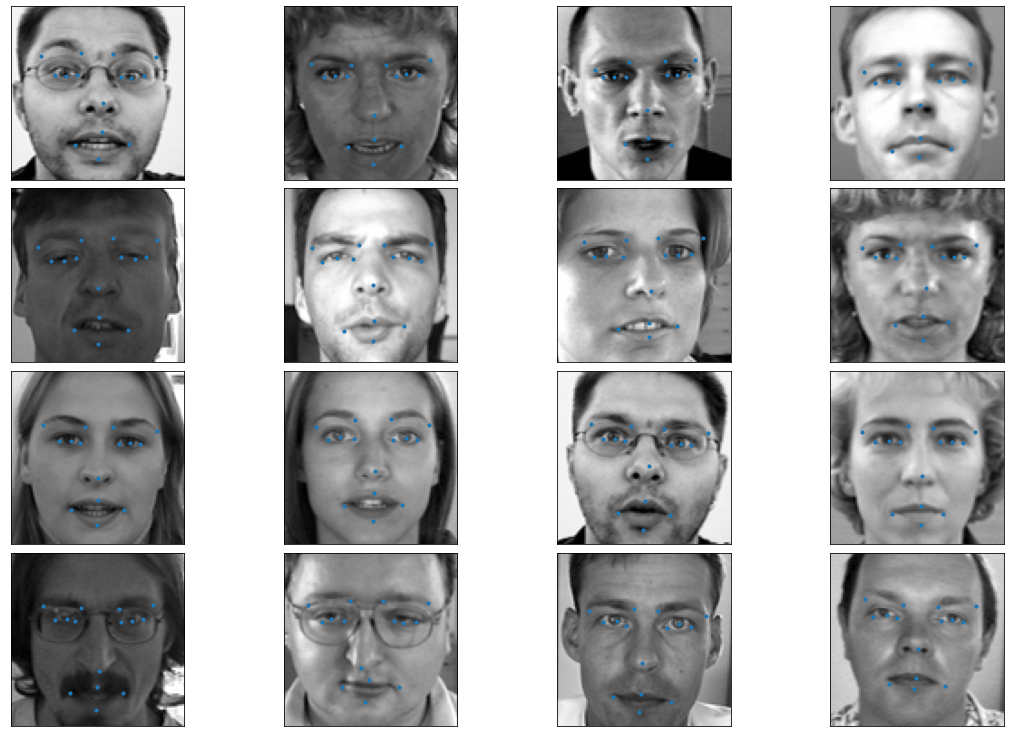

In [50]:
plot_16_test(x_test, preds_baseline)

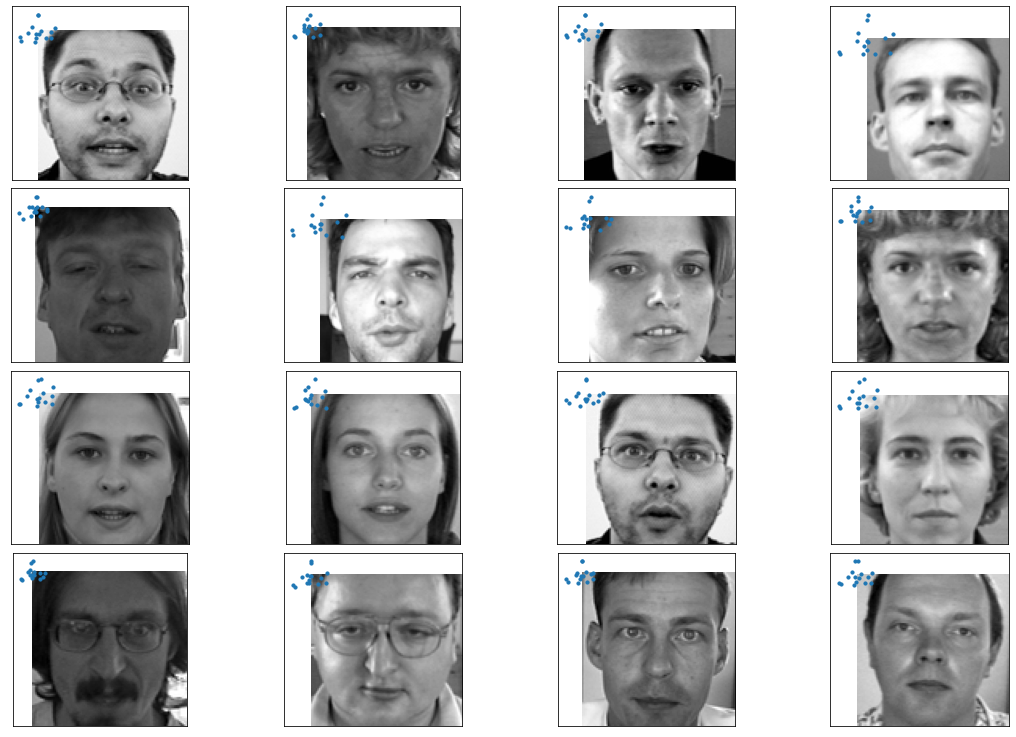

In [32]:
plot_16_test(x_test, preds)

# Submission

In [33]:
sample_sub = pd.read_csv('data/SampleSubmission.csv')
sample_sub.head()

,RowId,Location
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [34]:
header = list(training.drop('Image', axis=1).columns)
header

['left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'nose_tip_x',
 'nose_tip_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [35]:
test_predicts = pd.DataFrame(preds_baseline, columns = header)
test_predicts

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,0.520927,8.814082,1.574606,6.114047,5.606770,-10.007649,-6.836741,-5.667806,6.801394,5.110353,...,-1.362775,0.523591,3.233791,0.788784,-1.578833,-4.262550,6.847687,-1.643226,-3.870961,-0.779640
1,1.347501,8.010418,2.779485,4.733010,6.158674,-5.997120,-4.672901,-4.915671,3.667119,5.117864,...,-1.125402,-0.445063,2.222624,-1.193097,-0.672358,-4.195404,5.559572,-0.279095,-2.766420,-1.152804
2,2.804453,8.262819,4.724646,7.566339,4.763671,-7.421634,-3.788470,-5.136735,4.349832,3.098386,...,-2.686893,-0.636767,4.096290,-4.079071,0.892500,-4.390339,8.317386,2.484875,-2.122700,-1.109825
3,-0.374468,14.340456,4.010243,8.439822,10.019522,-12.116735,-7.580183,-8.307878,8.357033,10.219267,...,-1.699993,0.157271,2.431725,-3.538314,0.972141,-5.107301,9.210565,0.955091,-4.676032,0.815244
4,0.078752,6.667092,1.757447,3.234466,5.102696,-6.169565,-3.418811,-4.915154,4.566255,4.840530,...,0.230286,0.137631,2.267417,0.582536,-1.119934,-2.569623,4.148620,-0.342723,-2.098944,0.253873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,-0.279716,12.164396,3.622329,2.052737,5.241288,-10.214627,-7.054900,-8.327579,5.747276,4.779270,...,-2.450288,-0.137577,4.372412,-0.479024,0.870009,-4.338902,7.679837,2.246928,-4.664536,1.717571
1779,1.559836,13.880321,2.731861,9.620533,8.519218,-9.669958,-3.412651,-5.845893,6.206209,5.946566,...,-1.494235,-1.245786,1.865920,-0.484994,-1.014971,-4.046955,6.882174,-1.430117,-3.282332,0.847288
1780,-0.628704,10.504287,3.436666,5.541178,7.438103,-7.631924,-6.912504,-6.502888,5.644066,7.361382,...,0.218247,-0.858755,1.911063,-0.732606,-0.177976,-3.979427,6.072080,0.467800,-1.980644,-0.514351
1781,0.463527,12.349562,3.230050,8.277536,5.854989,-11.552607,-4.155663,-8.203363,6.406487,9.581265,...,0.685599,-1.803762,2.115964,1.205006,-1.993972,-5.299553,5.299780,1.179163,-2.715646,-1.316770


In [36]:
IdLookupTable = pd.read_csv(os.path.join('data', 'IdLookupTable.csv'))
for i in range(IdLookupTable.shape[0]):
    IdLookupTable.Location[i] = test_predicts.loc[IdLookupTable.ImageId[i]-1][IdLookupTable.FeatureName[i]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
sample_sub.Location = IdLookupTable.Location.astype(int)
my_submission = sample_sub
my_submission

,RowId,Location
0,1,0
1,2,8
2,3,1
3,4,6
4,5,5
...,...,...
27119,27120,4
27120,27121,0
27121,27122,-1
27122,27123,-2


In [38]:
my_submission.to_csv('submission.csv', index=False)

# Test with custom image
Test your own face!
- Images are cropped with 1:1 ration in the center and converted to greyscale.

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps

def crop_image(image):
    width, height = image.size
    if width == height:
        return image
    offset  = int(abs(height-width)/2)
    if width>height:
        image = image.crop([offset,0,width-offset,height])
    else:
        image = image.crop([0,offset,width,height-offset])
    return image

Image size = (96, 96)


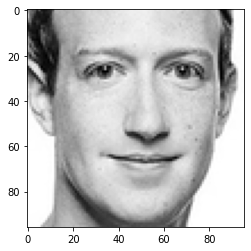

In [52]:
image_path = 'face.jpg'

img = Image.open(image_path).convert('L')
img = crop_image(img)
img = img.resize((96,96), Image.ANTIALIAS)
imgplot = plt.imshow(img, cmap='gray')
print(f'Image size = {img.size}')

In [53]:
test_img = np.asarray(img).reshape(1,96,96,1)
test_img.shape

(1, 96, 96, 1)

In [54]:
x_train[69].shape

(96, 96, 1)

### Detection with baseline model

CPU times: user 33.1 ms, sys: 60 µs, total: 33.2 ms
Wall time: 31.5 ms


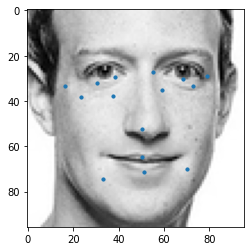

In [55]:
%time pred_y = model_baseline.predict(test_img)
plot_sample(test_img[0], pred_y[0], plt)
plt.show()

### Detection with Resnet-50 model

CPU times: user 42.2 ms, sys: 3.22 ms, total: 45.4 ms
Wall time: 42.8 ms


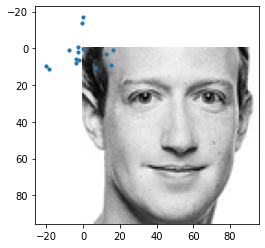

In [56]:
%time pred_y = model.predict(test_img)
plot_sample(test_img[0], pred_y[0], plt)
plt.show()

The model does not seem to detect lizard faces...